#1. Setup
Importing all the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

Mount Google Drive to import the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.1 Data

Downloading the cleaned data and setting it up for the model with various functions.

Function to further tidy the data and convert it to the correct data type.

In [ ]:
def csv_to_longlist(source):

  df = pd.read_csv(source)

  output_list = []

  for i, row in df.iterrows():
    text = str(row['text'])
    category = row['category']
    words = re.sub(r"[^a-zA-Z0-9]", " ", text) # Remove none letter/number characters
    words = words.lower() # lowercase everything
    output_list.append([words, category]) # put data together

  return output_list

In [ ]:
# Import the training, validation, and testing data
train_dest = '/content/drive/MyDrive/ASP360Project/Data/train.csv'
val_dest = '/content/drive/MyDrive/ASP360Project/Data/val.csv'
test_dest = '/content/drive/MyDrive/ASP360Project/Data/test.csv'

train_data = csv_to_longlist(train_dest)
val_data = csv_to_longlist(val_dest)
test_data = csv_to_longlist(test_dest)

train_data = pd.DataFrame(train_data, columns = ['text', 'category'])
val_data = pd.DataFrame(val_data, columns = ['text', 'category'])
test_data = pd.DataFrame(test_data, columns = ['text', 'category'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32846 entries, 0 to 32845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      32846 non-null  object
 1   category  32846 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 513.3+ KB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32846 entries, 0 to 32845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      32846 non-null  object
 1   category  32846 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 513.3+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10948 entries, 0 to 10947
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10948 non-null  object
 1   category  10948 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 171.2+ KB


In [ ]:
# default word frequency count parameters, the hyperparameter we will look at later is the max_features (or features used)
default_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,
                             max_features = 5000)

In [ ]:
# obtain the bag of words using a vectorizer
def get_word_count (vectorizer, data):
  transformed_data = data.to_numpy()
  transformed_data = vectorizer.fit_transform(transformed_data)
  transformed_data = transformed_data.toarray()
  return transformed_data

In [ ]:
# split into two arrays, one for the data labels and one for the text count
train_labels = train_data['category'].to_numpy()
train_texts = get_word_count(default_vectorizer, train_data['text'])

In [ ]:
val_labels = val_data['category'].to_numpy()
val_texts = get_word_count(default_vectorizer, val_data['text'])

In [ ]:
test_labels = test_data['category'].to_numpy()
test_texts = get_word_count(default_vectorizer, test_data['text'])

##1.2 Setting up the Random Forest

The parameters are set to the generally recommended/used ones [1]. The Gini impurity splitting rule is a commmonly used setting. The minimum number of samples in a leaf node is set to 1 since this is a classification problem. The number of trees (n_estimators) is tuned between 500-1,000 to minimize runtime and maximize accuracy. The number of features at each split (max_features), is determined to be most efficient at sqrt(total features). Finally bootstrapping is used for sampling, where N samples drawn per tree where N is the same size as the original dataset.

[1] https://wires.onlinelibrary.wiley.com/doi/full/10.1002/widm.1301?casa_token=lFlSZLXwaNoAAAAA%3AoH145SpZmmun6hIuC6395n_2aTuUzo8cyHSyOSWSLV0Oev6J9-TqKav7wSCz7zyncckuiJYF9B6Hxg

In [ ]:
# train a random forest model
def random_forest_train (model, data, truths):
  result_model = model.fit(data, truths)
  return result_model

In [ ]:
# Sets up the default random forest, the n_esimators (number of trees) is a hyperparameter we will look at later
default_forest = RandomForestClassifier(criterion='gini',
                                min_samples_leaf=1,
                                n_estimators=500,
                                max_features='sqrt',
                                bootstrap=True)

#2. Training the Model
Training the model using default model values as previously shown. Then the accuracy will be found using the validation dataset. This will help in the next step of tuning the parameters.

In [ ]:
# Train the random forest model on the training data
default_trained_forest = random_forest_train(default_forest, train_texts, train_labels)

In [ ]:
# Get the model's predictions on the validation data
val_outputs = default_trained_forest.predict(val_texts)

# Get the accuracy of the model's predictions on the validation data
val_accuracy = accuracy_score(val_labels, val_outputs)

print ("Validation Accuracy: ", val_accuracy)

Validation Accuracy:  0.5546218487394958


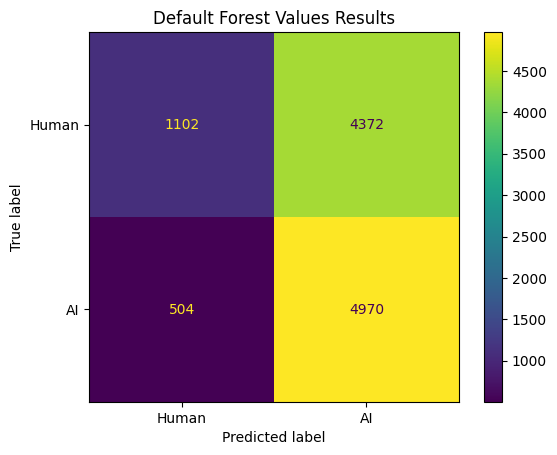

In [ ]:
# Format the validation predictions from the model & the acutal validation values in a 2D array setup for a confusion matrix
val_cm = confusion_matrix(val_labels, val_outputs)

# Plot the confusion matrix for the validation data
val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=["Human","AI"])
val_disp.plot()
plt.title("Default Forest Values Results")
plt.show()

In [ ]:
f1 = f1_score(val_labels, val_outputs)
print("F1 Score: ", f1)

F1 Score:  0.6708963282937365


# 3. Hyperparameter Tuning

For the random forest model, the important hyperparameters to tune are the number of features and total number of trees. For the features, we can test the number of features up to an amout that maximizes our avalible amount of RAM. For the hyperparameters, we can do this by running through the common range of number of trees (500 to 1,000) and calculating the F1 score for each.

##3.1 Number of Trees

Since the range of trees we will be looking at is 500-1000, we will be iterating through them in increments of 100.

In [ ]:
trees_f1 = []
trees_accuracy = []
num_of_trees = [500, 600, 700, 800, 900, 1000]

In [ ]:
for i in num_of_trees:
  num_of_trees_forest = RandomForestClassifier(criterion='gini',
                                  min_samples_leaf=1,
                                  n_estimators=i,
                                  max_features='sqrt',
                                  bootstrap=True)
  forest = random_forest_train(num_of_trees_forest, train_texts, train_labels)
  val_outputs = forest.predict(val_texts)
  accuracy = accuracy_score(val_labels, val_outputs)
  trees_accuracy.append(accuracy)
  f1 = f1_score(val_labels, val_outputs)
  trees_f1.append(f1)

In [ ]:
print ("F1 Scores: " + str(trees_f1))
print ("Accuracy: " + str(trees_accuracy))

F1 Scores: [0.6650782845473111, 0.6636376544086328, 0.6649350649350648, 0.6822985931266186, 0.6663350152796531, 0.6641323477648715]
Accuracy: [0.5506028498355864, 0.5672268907563025, 0.5522469857508221, 0.5854037267080745, 0.5711545487760321, 0.5642126415783705]


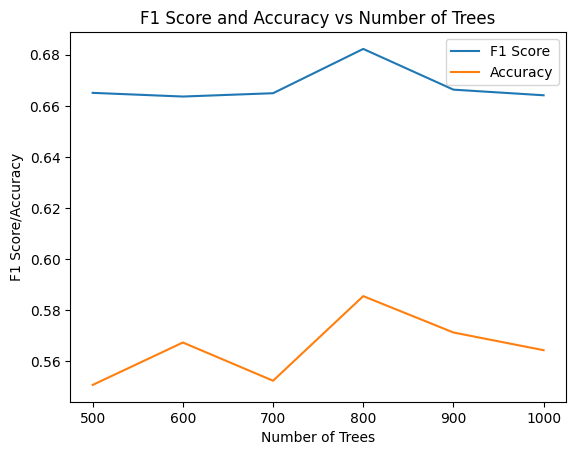

In [ ]:
plt.plot(num_of_trees, trees_f1)
plt.plot(num_of_trees, trees_accuracy)
plt.legend(['F1 Score', 'Accuracy'])
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score/Accuracy')
plt.title('F1 Score and Accuracy vs Number of Trees')
plt.show()

##3.2 Number of Features
We are limited by the avalible resources for this hyperparameter. So we will iterate from 500 until the resources are close to maxed out.

In [ ]:
features_accuracy = []
features_f1 = []
num_of_features = [3000, 4000, 5000, 6000, 7000]

In [ ]:
for i in num_of_features:
  features_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,
                             max_features = i)
  train_texts = get_word_count(features_vectorizer, train_data['text'])
  val_texts = get_word_count(features_vectorizer, val_data['text'])
  forest = random_forest_train(default_forest, train_texts, train_labels)
  val_outputs = forest.predict(val_texts)
  accuracy = accuracy_score(val_labels, val_outputs)
  features_accuracy.append(accuracy)
  f1 = f1_score(val_labels, val_outputs)
  features_f1.append(f1)

In [ ]:
print ("F1 Scores: " + str(features_f1))
print ("Accuracy: " + str(features_accuracy))

F1 Scores: [0.5890507106509913, 0.6503209838347901, 0.6515799641230854, 0.5867891204521369, 0.5885922330097088]
Accuracy: [0.5721592985020095, 0.5870478626233102, 0.5387285348922177, 0.46574716843259045, 0.44263792473511143]


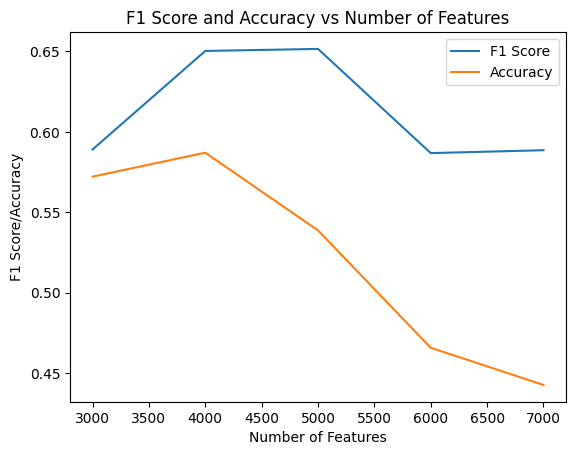

In [ ]:
plt.plot(num_of_features, features_f1)
plt.plot(num_of_features, features_accuracy)
plt.legend(['F1 Score', 'Accuracy'])
plt.xlabel('Number of Features')
plt.ylabel('F1 Score/Accuracy')
plt.title('F1 Score and Accuracy vs Number of Features')
plt.show()

#4.0 Final Model
Based on the results from the previous section, the number of trees will be set to 800 and the number of features will be set to .


The model will be trained with the newly determined hyperparameters then tested against the test data to calculate a final accuracy and F1 score.

In [ ]:
final_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,
                             max_features = 4000)

final_forest = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             n_estimators=800,
                             max_features='sqrt',
                             bootstrap=True)



In [ ]:
final_train_texts = get_word_count(final_vectorizer, train_data['text'])
final_val_texts = get_word_count(final_vectorizer, val_data['text'])
final_test_texts = get_word_count(final_vectorizer, test_data['text'])

In [ ]:
final_forest_model = random_forest_train(final_forest, final_train_texts, train_labels)

In [ ]:
final_val_outputs = final_forest_model.predict(final_val_texts)
final_val_accuracy = accuracy_score(val_labels, final_val_outputs)
print ("Validation Accuracy: ", final_val_accuracy)
print("Validation F1 Score: ", f1_score(val_labels, final_val_outputs))

Validation Accuracy:  0.5938070880526124
Validation F1 Score:  0.6521160916842682


In [ ]:
test_outputs = final_forest_model.predict(final_test_texts)
test_accuracy = accuracy_score(test_labels, test_outputs)
print ("Test Accuracy: ", test_accuracy)
print("Test F1 Score: ", f1_score(test_labels, test_outputs))

Test Accuracy:  0.6392948483741323
Test F1 Score:  0.6827347955330602


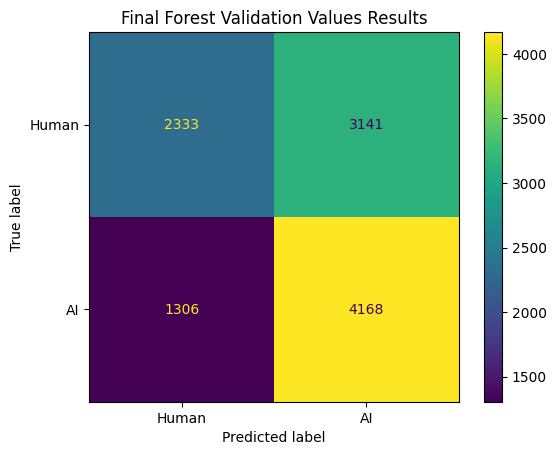

In [ ]:
# Format the validation predictions from the model & the acutal validation values in a 2D array setup for a confusion matrix
val_cm = confusion_matrix(val_labels, final_val_outputs)

# Plot the confusion matrix for the validation data
val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=["Human","AI"])
val_disp.plot()
plt.title("Final Forest Validation Values Results")
plt.show()

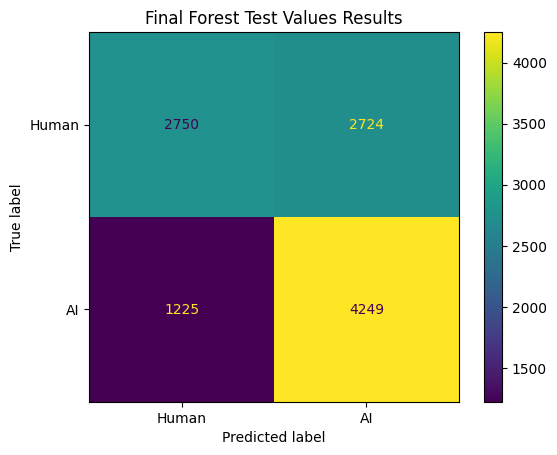

In [ ]:
# Format the validation predictions from the model & the acutal validation values in a 2D array setup for a confusion matrix
test_cm = confusion_matrix(test_labels, test_outputs)

# Plot the confusion matrix for the validation data
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["Human","AI"])
test_disp.plot()
plt.title("Final Forest Test Values Results")
plt.show()